In [ ]:
!pip install pyross
import pyross

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

from google.colab import drive
drive.mount('/content/drive')

## functions for generating and infering data

In [2]:
def generate_model(x0, Ni, model_spec, parameters):
  M = 3; N = sum(Ni); CM = np.array([[3, 0.8, 0.1], [0.8, 2, 0.5], [0.1, 0.5, 1  ]])

  def contactMatrix(t):
      if t<50:
          xx = CM
      elif 50<=t<200:
          xx = 0.5*CM
      elif 200<=t<300:
          xx = 0.9*CM
      elif 300<=t<400:
          xx = 0.5*CM
      else:
          xx = CM
      return xx

  model = pyross.deterministic.Model(model_spec, parameters, M, Ni)
  data = model.simulate(x0, contactMatrix, Tf = 1000, Nf = 1001)
  return data

def generate_SEIR(x0, Ni):
  parameters = {'beta'  : 0.05,
              'gI' : 0.1, 
              'gE' : 0.5
              }
  model_spec = {"classes" : ["S", "E", "I", "R"],

                "S" : { "infection" : [ ["I", "S", "-beta"] ] },

                "E" : { "linear"    : [ ["E", "-gE"] ],
                        "infection" : [ ["I", "S", "beta"] ] },
                
                "I" : { "linear"    : [ ["E", "gE"],
                                        ["I", "-gI"] ] },
                
                "R" : { "linear"    : [ ["I", "gI"] ]}
  }

  model = generate_model(x0, Ni, model_spec, parameters)
  return np.array(model['X'])


def infer_model(x, Ni, Tf_inference, model_spec, parameters, priors):
  M = 3; N = sum(Ni); CM = np.array([[3, 0.8, 0.1], [0.8, 2, 0.5], [0.1, 0.5, 1  ]])

  def contactMatrix(t):
      if t<50:
          xx = CM
      elif 50<=t<200:
          xx = 0.5*CM
      elif 200<=t<300:
          xx = 0.9*CM
      elif 300<=t<400:
          xx = 0.5*CM
      else:
          xx = CM
      return xx

  estimator = pyross.inference.Model(model_spec, parameters, M, Ni)
  estimator.set_lyapunov_method('euler')
  return estimator.infer(x, Tf_inference, priors, contactMatrix, global_max_iter=5, local_max_iter=50, verbose=True)


## BMA

In [3]:
# generate SEIR model data
Ni=10000*np.ones(3); x0 = np.array([9980, 9980, 9980, 0, 0, 0, 20,   20,  20, 0, 0, 0 ])
data_array = generate_SEIR(x0, Ni)

# infer the parameters for two different models using the first 200 points
Tf_infer = 200; Nf_infer = Tf_infer + 1

# only use S and I data for inference
x_1 = (data_array[:,[0,1,2,6,7,8]][:Nf_infer]).astype('float')

# infer SI model
inference_parameters_SI = {
    'beta' : 0.02, 
    'gI' : 0.1, 
}
model_spec_SI = {
    "classes" : ["S", "I"],

    "S" : { "linear"    : [],
            "infection" : [ ["I", "S", "-beta"] ] },
    "I" : { "linear"    : [ ["I", "-gI"] ],
            "infection" : [ ["I", "S","beta"] ] } 
}
beta_g = 0.005; beta_std = 0.01 
gI_g = 0.1; gI_std = 0.1
eps = 1e-4 
param_priors_SI = {
    'beta':{
        'mean': beta_g, 
        'std': beta_std, 
        'bounds': [eps, 0.5]},
    'gI':{
        'mean': gI_g, 
        'std': gI_std, 
        'bounds': [eps, 0.6]}
}

result_SI = infer_model(x_1, Ni, Tf_infer, model_spec_SI, inference_parameters_SI, param_priors_SI)

Starting global minimisation ...
         Switching to single processed mode (cma_processes = 1).
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 2 (seed=2230636659, Wed Sep  1 14:48:34 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 6.247432588731870e+03 1.0e+00 1.65e+00  2e-02  1e-01 0:03.2
    2     32 3.888377508584550e+03 1.4e+00 2.35e+00  3e-02  2e-01 0:06.8
    3     48 2.053963547017088e+03 2.0e+00 3.51e+00  5e-02  2e-01 0:13.6
    4     64 1.897868197582268e+03 2.2e+00 3.07e+00  3e-02  2e-01 0:20.1
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  1897.8681975822683
Starting local minimisation...
Optimal value (local minimisation):  1822.0857446443838


In [4]:
# use S, E and I data for inference
x_2 = (data_array[:,0:9][:Nf_infer]).astype('float')

inference_parameters_SEI = {
    'beta' : 0.02, 
    'gI' : 0.1,
    'gE' : 0.1
} 
model_spec_SEI = {
    "classes" : ["S", "I", "E"],

    "S" : { "linear"    : [],
            "infection" : [ ["I", "S", "-beta"] ] },
    "I" : { "linear"    : [ ["E", "gE"],
                           ["I", "-gI"] ] },
    "E" : { "linear"    : [ ["E", "-gE"] ],
            "infection" : [ ["I", "S", "beta"] ] }
}

beta_g = 0.005; beta_std = 0.01 
gI_g = 0.1; gI_std = 0.1
gE_g = 0.1; gE_std = 0.1
eps = 1e-4 
param_priors_SEI = {
    'beta':{
        'mean': beta_g, 
        'std': beta_std, 
        'bounds': [eps, 0.5]},
    'gI':{
        'mean': gI_g, 
        'std': gI_std, 
        'bounds': [eps, 0.6]},
    'gE':{
        'mean': gE_g, 
        'std': gE_std, 
        'bounds': [eps, 0.6]}
}

result_SEI = infer_model(x_2, Ni, Tf_infer, model_spec_SEI, inference_parameters_SEI, param_priors_SEI)

Starting global minimisation ...
         Switching to single processed mode (cma_processes = 1).
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=2096658837, Wed Sep  1 14:49:05 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.327093208118030e+04 1.0e+00 1.14e+00  1e-02  1e-01 0:04.0
    2     32 1.745889760696557e+04 1.5e+00 2.15e+00  3e-02  2e-01 0:07.8
    3     48 1.166956607708891e+04 1.8e+00 3.56e+00  5e-02  4e-01 0:11.9
    4     64 7.758767282582960e+03 1.9e+00 6.49e+00  9e-02  6e-01 0:16.2
    5     80 3.010850108067083e+03 2.2e+00 1.05e+01  1e-01  9e-01 0:20.7
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  3010.8501080670826
Starting local minimisation...
Optimal value (local minimisation):  2707.5819709261095


In [5]:
parameters = result_SI['params_dict']
model_spec = {
    "classes" : ["S", "I"],

    "S" : { "linear"    : [],
            "infection" : [ ["I", "S", "-beta"] ] },
    "I" : { "linear"    : [ ["I", "-gI"] ],
            "infection" : [ ["I", "S","beta"] ] } 
}

Ni=10000*np.ones(3); x0 = np.array([9980, 9980, 9980, 20,   20,  20 ])

SIR_forecast = generate_model(x0, Ni, model_spec, parameters)
data_array_2 = np.array(SIR_forecast['X'])

parameters = result_SEI['params_dict']
model_spec = {
    "classes" : ["S", "I", "E"],

    "S" : { "linear"    : [],
            "infection" : [ ["I", "S", "-beta"] ] },
    "I" : { "linear"    : [ ["E", "gE"],
                           ["I", "-gI"] ] },
    "E" : { "linear"    : [ ["E", "-gE"] ],
            "infection" : [ ["I", "S", "beta"] ] }
}

Ni=10000*np.ones(3); x0 = np.array([9980, 9980, 9980, 0,0,0, 20,   20,  20 ])

SEIR_forecast = generate_model(x0, Ni, model_spec, parameters)
data_array_3 = np.array(SEIR_forecast['X'])


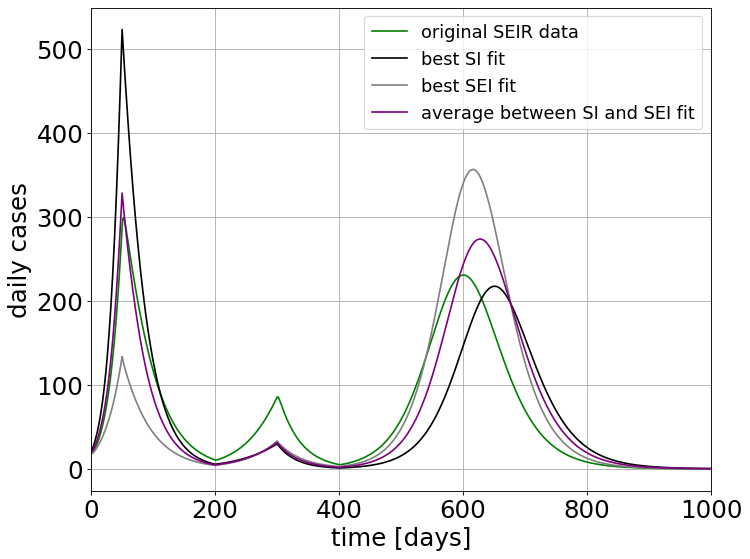

In [17]:
data_array_4 = (data_array_2[:,[0,1,2,3,4,5]] + data_array_3[:,[0,1,2,6,7,8]]) /2

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k'); plt.rcParams.update({'font.size': 22})
# plt.plot(data_array[:,0],color = 'royalblue')
plt.plot(data_array[:,6],color = 'green', label = 'original SEIR data')
# plt.plot(data_array_2[:,0],color = 'red')
plt.plot(data_array_2[:,3],color = 'black', label = 'best SI fit')
# plt.plot(data_array_3[:,0],color = 'orange')
plt.plot(data_array_3[:,6],color = 'grey', label = 'best SEI fit')
# plt.plot(data_array_4[:,0],color = 'pink')
plt.plot(data_array_4[:,3],color = 'purple', label = 'average between SI and SEI fit')
plt.legend(fontsize=16); plt.grid(); plt.autoscale(enable=True, axis='x', tight=True); plt.xlabel("time [days]"); plt.ylabel("daily cases"); plt.show()
